This is the implementation of DCGAN with normalize input and one-sided label smoothing:
- Number of epochs: 100
- lr: 0.0002
- Add results dir for images and loss
- Add weight_decay: 1e-4

- input: normalize (0.5, 0.5, 0.5)
- sided_label: 0.9 ```torch.from_numpy(np.full(batch_size, 0.9, np.float32))```
- Freezing: stop update D when loss D < 0.7 loss G

# Import

In [1]:
import argparse
import os
import time
import pickle
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchnet.meter import AverageValueMeter

# Define Arguments

In [3]:
%ll ./data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/

total 0
drwxr-xr-x    3 hoangnguyen  staff    102 24 May 11:21 7 For All Mankind Kids/
drwxr-xr-x   18 hoangnguyen  staff    612 24 May 11:21 ALDO/
drwxr-xr-x  351 hoangnguyen  staff  11934 24 May 11:21 ASICS/
drwxr-xr-x   47 hoangnguyen  staff   1598 24 May 11:21 ASICS Kids/
drwxr-xr-x   12 hoangnguyen  staff    408 24 May 11:21 Aetrex/
drwxr-xr-x    7 hoangnguyen  staff    238 24 May 11:21 Agatha Ruiz De La Prada Kids/
drwxr-xr-x   20 hoangnguyen  staff    680 24 May 11:21 Ahnu/
drwxr-xr-x    6 hoangnguyen  staff    204 24 May 11:21 Alexander McQueen/
drwxr-xr-x   29 hoangnguyen  staff    986 24 May 11:21 Allrounder by Mephisto/
drwxr-xr-x   14 hoangnguyen  staff    476 24 May 11:21 Altra Zero Drop Footwear/
drwxr-xr-x   22 hoangnguyen  staff    748 24 May 11:21 Amiana/
drwxr-xr-x    3 hoangnguyen  staff    102 24 May 11:21 Anne Klein/
drwxr-xr-x    4 hoangnguyen  staff    136 24 May 11:21 Arcopedico/
drwxr-xr-x    3 hoangnguyen  staff    102 24 May 11:21 Ariat/
drwxr-xr-x    7 hoang

In [4]:
parser = {
    'data_path': './data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/',
    'epochs': 100,
    'batch_size': 64,
    'lr': 0.0002,
    'image_size': 136,
    'scale_size': 64,
    'z_dim': 100,
    'G_features': 64,
    'D_features': 64,
    'image_channels': 3,
    'beta1': 0.5,
    'cuda': True,
    'seed': 7,
    'workers': 2,
    'results': './resultsDCGAN3_0523/'
}
args = argparse.Namespace(**parser)
args.image_results = args.results + 'images/'
args.loss_results = args.results + 'loss/'
args.cuda = args.cuda and torch.cuda.is_available()

if not os.path.isdir(args.data_path):
    os.makedirs(args.data_path)
if not os.path.isdir(args.results):
    os.makedirs(args.results)
if not os.path.isdir(args.image_results):
    os.makedirs(args.image_results)
if not os.path.isdir(args.loss_results):
    os.makedirs(args.loss_results)
    
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Prepare Data

**Note: all iamges have size 136x102**

In [5]:
from folder import ImageFolder

In [6]:
from torchvision.transforms import ToPILImage
to_image = ToPILImage()

In [7]:
def get_loader(image_root, batch_size, scale_size, num_workers=2, shuffle=True):
    #image_root = os.path.join(root, 'splits', split)
    dataset = ImageFolder(root=image_root, transform=transforms.Compose([
            transforms.Pad(34, fill=(255, 255, 255)), # padding images with (255,255,255) --> pad 255 in 3 channels
            transforms.CenterCrop((136,136)),
            transforms.Scale(scale_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=int(num_workers))
    #data_loader.shape = [int(num) for num in dataset[0][0].size()]

    return data_loader

In [8]:
dataloader = get_loader(args.data_path, args.batch_size, args.scale_size)

Found 12856 images in subfolders of: ./data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/


## Test One Image

In [9]:
test_image = 0
for data, _ in dataloader:
    print(data[0])
    test_image = data[0]
    break


(0 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

(1 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

(2 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...            

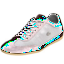

In [10]:
to_image(test_image)

# Define Model

## Define G

In [11]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(args.z_dim, args.G_features * 8,
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(args.G_features * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(args.G_features * 8, args.G_features * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(args.G_features * 4, args.G_features * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(args.G_features * 2, args.G_features,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(args.G_features, args.image_channels,
                               4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, x):
        return self.main(x)

## Define D

In [12]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(args.image_channels, args.D_features,
                      4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(args.D_features, args.D_features * 2,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(args.D_features * 2, args.D_features * 4,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(args.D_features * 4, args.D_features * 8,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(args.D_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

## Save losses

In [13]:
class Results():
    def __init__(self, results_path):
        self.D_losses = []
        self.G_losses = []
        self.D_reals = []
        self.D_fakes = []
        self.G_reals = []
        self.results_path = results_path
    
    def save_losses(self, D_loss, G_loss, D_real, D_fake, G_real):
        self.D_losses.append(D_loss)
        self.G_losses.append(G_loss)
        self.D_reals.append(D_real)
        self.D_fakes.append(D_fake)
        self.G_reals.append(G_real)
        
    def save_to_disk(self):
        f = open(self.results_path + "D_losses.pkl", "wb")
        pickle.dump(self.D_losses, f)
        f= open(self.results_path + "G_losses.pkl", "wb")
        pickle.dump(self.G_losses, f)
        f = open(self.results_path + "D_reals.pkl", "wb")
        pickle.dump(self.D_reals, f)
        f = open(self.results_path + "D_fakes.pkl", "wb")
        pickle.dump(self.D_fakes, f)
        f = open(self.results_path + "G_reals.pkl", "wb")
        pickle.dump(self.G_reals, f)
        

## Define Train and Generate

In [14]:
c = np.full(5, 1, np.float32)

In [15]:
c = torch.from_numpy(np.full(5, 1, np.float32))

In [16]:
c


 1
 1
 1
 1
 1
[torch.FloatTensor of size 5]

In [17]:
real_label = torch.ones(5)

In [18]:
real_label


 1
 1
 1
 1
 1
[torch.FloatTensor of size 5]

In [19]:
c == real_label


 1
 1
 1
 1
 1
[torch.ByteTensor of size 5]

In [20]:
def train(args, data_loader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses):
    D_losses = AverageValueMeter()
    G_losses = AverageValueMeter()
    D_reals = AverageValueMeter()
    D_fakes = AverageValueMeter()
    G_reals = AverageValueMeter()
    
    start = time.time()
    # call Variable after .cuda()
    for i, (real, _) in enumerate(data_loader):
        batch_size = real.size(0)
        real_label = torch.from_numpy(np.full(batch_size, 0.9, np.float32)) #modify here
        fake_label = torch.zeros(batch_size)
        z = torch.randn(batch_size, args.z_dim, 1, 1)
        
        if args.cuda:
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()
            real = real.cuda()
            z = z.cuda()
        real_label = Variable(real_label)
        fake_label = Variable(fake_label)
        real = Variable(real)
        z = Variable(z)
        
        real_output = netD(real)
        D_real_loss = criterion(real_output, real_label)
        D_real = real_output.data.mean()
        
        if D_losses.value()[0] < 0.7*G_losses.value()[0]:
            # train G
            fake = netG(z)
            fake_output = netD(fake.detach())
            D_fake_loss = criterion(fake_output, fake_label)
            D_fake = fake_output.data.mean()
        
            D_loss = D_real_loss + D_fake_loss
            netD.zero_grad()
            D_loss.backward()
            D_optimizer.step()
        
        else:
            # train G
            fake = netG(z)
            fake_output = netD(fake.detach())
            D_fake_loss = criterion(fake_output, fake_label)
            D_fake = fake_output.data.mean()
        
            D_loss = D_real_loss + D_fake_loss
            netD.zero_grad()
            D_loss.backward()
            D_optimizer.step()
            
            #train D
            output = netD(fake)
            G_loss = criterion(output, real_label)
            G_real = output.data.mean()
            netG.zero_grad()
            G_loss.backward()
            G_optimizer.step()
        
        # update loss
        D_losses.add(D_loss.data.cpu()[0] * batch_size, batch_size)
        G_losses.add(G_loss.data.cpu()[0] * batch_size, batch_size)
        D_reals.add(D_real * batch_size, batch_size)
        D_fakes.add(D_fake * batch_size, batch_size)
        G_reals.add(G_real * batch_size, batch_size)
        
    print("=> EPOCH {} | Time: {}s | D_loss: {:.4f} | G_loss: {:.4f}"
          " | D_real: {:.4f} | D_fake: {:.4f} | G_real: {:.4f}"
          .format(epoch, round(time.time()-start), D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0]))
    result_losses.save_losses(D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0])

In [21]:
def generate(args, netG, epoch):
    z = torch.randn(args.batch_size, args.z_dim, 1, 1)
    if args.cuda:
        z = z.cuda()
    fake = netG(Variable(z, volatile=True))
    save_image(fake.data.cpu(), os.path.join(args.image_results,
        "fake_sample_epoch_{:02d}.png".format(epoch)), normalize=True)

## Create Model, Define Loss and Optimizer

In [22]:
netG = _netG()
netD = _netD()
criterion = nn.BCELoss()
if args.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()

In [23]:
D_optimizer = optim.Adam(netD.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)
G_optimizer = optim.Adam(netG.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)

## Run Train

In [24]:
result_losses = Results(args.loss_results)
for epoch in range(0, args.epochs):
    train(args, dataloader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses)
    generate(args, netG, epoch)

Process Process-4:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.

KeyboardInterrupt: 

## Save loss

In [ ]:
result_losses.save_to_disk()

## Get one REAL Image

In [72]:
sample, _ = iter(dataloader).next()
save_image(sample, os.path.join(args.results, "real_sample.png"))